# Force Fields for Materials

Machine learning force fields for studying materials has become increasingly popular. However, the large size of the physical systems associated with most materials require some tricks to keep the amount of compute and required data sufficiently low. 

In this tutorial, we will describe some of those tricks and how they can be implemented in the SchNetPack pipeline, namely:
- **periodic boundary conditions (PBC)**: PBC allow to effectively reduce the number of simulated particles to only a fraction of the actual system's size. This is achieved by considering a relatively small simulation box, which is periodically repeated at its boundaries. In most cases, the resulting simulated periodic structure is a good approximation if the system under consideration.
- **cached neighbor lists**: For large systems, the computation of all neighbors is expensive. In the training procedure this problem can be cirumvented by utilizing neihbor list caching. This way, the neighbors must only be computed in the first epoch. In the subsequent epochs the cached neihbor lists can be loaded, which reduces the training time tremendously.
- **neighbor lists with skin buffer**: In the scope of molecular dynamics simulations or structure relaxations, caching neighbor lists is not util since the neighborhoods change with each integration step. Hence, it is recommended to use a neighbor list that utilizes a so-called skin buffer. Latter represents a thin layer that extends the cutoff region. It allows to reuse the calculated neighbor lists for samples with similar atomic positions. Only when at least one atom penetrates the skin buffer, the neighbor list is recalculated.
- **filtering out neighbors (neighbor list postprocessing)**: Also in the feed forward pass of the network, a large number of neighbors, and thus interactions, can result in slow inference and training. In some scenarios it is crucial to have as few operations as possible in the model to ensure fast inference. This can be achieved, e.g., by filtering out some neighbors from the neighbor list.
- **prediction target emphasizing**: In some occations it may be useful to exclude the properties of some atoms from the training procedure. For example you might want to focus the training on the forces of only some atoms and neglect the rest. An examplary use case would be a model used for structure optimization where some atoms are fixed during the simulation (zero forces). Or when filtering out neighbors of certain atoms, it might be reasonable to exclude the corresponding atomic properties from the training loss. 


In the following tutorial, we will first describe how the dataset must be prepared to allow for utilizing the above-mentioned tricks. Subsequently, we explain how the configs in the SchNetPack framework must be adapted for training and inference, accordingly. The dataset preparation part is based on the tutorial script "tutorial_01_preparing_data". Please make sure you have understood the concepts introduced there, before continuing with this tutorial.

## Preparing the Dataset

First we will demonstrate how to prepare the dataset to enable the use of periodic boundary conditions (pbc). "tutorial_01_preparing_data" describes how to prepare your own data for SchNetPack. For the purpose of this tutorial we will create a new dataset and add the Si$_{16}$ diamond structure to the database. More structures can be added to the dataset by repeating the process with more datapoints in an iterative manner. In order to create the sample structure we need the atomic positions, the cell shape and the atom types. Furthermore, we want to add the properties "energy", "forces" and "stress" to our dataset.

In [4]:
import numpy as np

n_atoms = 16
positions = np.array([
    [5.88321935, 2.88297608, 6.11028356],
    [3.55048572, 4.80964742, 2.77677731],
    [0.40720652, 6.73142071, 3.88666154],
    [2.73860477, 0.96144918, 0.55409947],
    [0.40533082, 4.80977264, 0.55365277],
    [2.73798189, 2.88306742, 3.88717458],
    [5.88129464, 0.96133042, 2.77731562],
    [3.54993842, 6.73126316, 6.10980443],
    [0.4072795 , 2.88356071, 3.88798019],
    [2.7361945 , 4.80839638, 0.55454406],
    [5.8807282 , 6.732434  , 6.10842469],
    [3.55049053, 0.96113024, 2.77692083],
    [5.88118878, 4.80922032, 2.7759235 ],
    [3.55233987, 2.8843493 , 6.10940225],
    [0.4078124 , 0.96031906, 0.5555672 ],
    [2.73802399, 6.73163254, 3.88698037],
])
cell = np.array([
    [6.287023489207423, -0.00034751886075738795, -0.0008093810364881463],
    [0.00048186949720712026, 7.696440684406158, -0.001909478919115524],
    [0.0010077843421425583, -0.0033467698530393886, 6.666654324468158],
])
symbols=["Si"]*n_atoms
energy = np.array(-10169.33552017)
forces = np.array([
    [ 0.02808107, -0.02261815, -0.00868415],
    [-0.03619687, -0.02530285, -0.00912962],
    [-0.03512621,  0.02608594,  0.00913623],
    [ 0.02955523,  0.02289934,  0.0089936 ],
    [-0.02828359,  0.02255927,  0.00871455],
    [ 0.03636321,  0.02545969,  0.00911801],
    [ 0.0352177 , -0.02613079, -0.00927739],
    [-0.02963064, -0.0227443 , -0.00894253],
    [-0.03343582,  0.02324933,  0.00651742],
    [ 0.03955335,  0.0259127 ,  0.00306112],
    [ 0.03927719, -0.02677768, -0.00513233],
    [-0.0332425 , -0.02411682, -0.00464783],
    [ 0.03358715, -0.02328505, -0.00626828],
    [-0.03953832, -0.02600458, -0.00316128],
    [-0.03932441,  0.02681881,  0.0048871 ],
    [ 0.03314345,  0.0239951 ,  0.00481536],
])
stress = np.array([
    [-2.08967984e-02,  1.52890659e-06,  1.44133597e-06],
    [ 1.52890659e-06, -6.45087059e-03, -7.26463797e-04],
    [ 1.44133597e-06, -7.26463797e-04, -6.04950702e-03],
])

For the purpose of filtering out certain neighbors from the neighbor list, one has to specify a list of atom indices. Between the corresponding atoms, all interactions are neglected. In our examplary system we neglect all interactions between the atoms with index 4, 10, and 15.

In [5]:
filtered_out_neighbors = np.array([4, 10, 15])

To specify the atoms, which targets should be considered in the model optimization, one must define a list of booleans, indicating considered and neglected atoms. This boolean array should be stored in the database along with other sample properties such as, e.g., energy, forces, and the array of filtered out neighbors.

For our exemplary system of 16 atoms, the array of considered atoms could be defined as follows:

In [6]:
# initialize array specifying considered atoms
considered_atoms = np.ones(n_atoms, dtype=bool)

# atom 4 and atom 5 should be neglected in the model optimization
considered_atoms[[4, 10, 15]] = False

Before we can add our new data to a database for training, we will need to transform it to the correct format. The atomic structure of the new system is stored in an `ase.Atoms` object. In contrast to datasets without periodic boundary conditions we need to set the flag `pbc=True` when the `ase.Atoms` object is created. Both the chemical properties of the structure, as well as the settings arguments for filtering neighbors and defining the atoms to consider during training are stored in the data dictionary corresponding to the new structure. All properties of the data dictionary need to be stored as `np.ndarray`. Please note, that cell dependend properties need to be unsqueezed in the first dimension.

In [7]:
from ase import Atoms
atoms = Atoms(
    symbols=symbols,
    positions=positions,
    cell=cell,
    pbc=True,
)
data = dict(
    energy=np.array(energy),
    forces=np.array(forces),
    stress=np.array(stress),
    considered_atoms=considered_atoms,
    filtered_out_neighbors=filtered_out_neighbors,
)

Just as with molecular datasets, we can use the `create_dataset` function in oder to build a new database. Since we added the `considered_atoms` and `filtered_out_neighbors` to our data dictionary, we also need to define these unitless properties in the `property_unit_dict`. Please note, that all structures in a dataset need to have an equal set of properties. In case some structures do not filter out any neighbors, the `filtered_out_neighbors` has to be set with an empty list.

In [11]:
from schnetpack.data import create_dataset, AtomsDataFormat


new_dataset = create_dataset(
    datapath="./si16.db",
    format=AtomsDataFormat.ASE,
    distance_unit='Ang',
    property_unit_dict=dict(
        energy="eV",
        forces="eV/Ang",
        stress="eV/Ang/Ang/Ang",
        considered_atoms="",
        filtered_out_neighbors="",
    ),
)

We can now add our datapoint to the new dataset:

In [12]:
new_dataset.add_systems(
    property_list=[data],
    atoms_list=[atoms],
)

# Adapting the Configs in the SchNetPack Framework

Now we will cover, how to adapt config files to enable the use of the above mentioned tricks in SchNetPack's traning procedure and MD framework

### SchNetPack Training

Provided that appropriate neighbor list providers (ASE or MatScipy) are used, this is sufficient for using pbc in the SchNet/PaiNN framework.

The neighbor list caching is implemented in the schnetpack transform ``schnetpack.transform.CachedNeighborList``. SchNetPack provides a transform for caching neighbor lists. It basically functions as a wrapper around a common neighbor lists. For further information regarding the CachedNeighborList please refer to the corresponding docstring in the schnetpack code.

Neighbors can be filtered out by using the neighbor list postprocessing transform ``schnetpack.transform.FilterNeighbors``.

To ensure that only the specified atoms are considered for the training on a certain property, the respective ModelOutput object has to be adapted. This is achieved by using so-called constraints. Each ModelOutput object takes a list of constraints. For a precise explanation on how to use ``schnetpack.task.ModelOutput`` please refer to notebook "tutorial_02_qm9". To specify the selection of atoms for training we use the constraint transform ``schnetpack.task.ConsiderOnlySelectedAtoms``. It has the attribute selection_name, which should be a string linking to the array of specified atoms stored in the database.

For adding the stress property to the learning task, we need to make some modifications to configs. First of all, the `Forces` output module needs a stress key and the flag `calc_stress=True` needs to be set. Then we also need to add the stress predictions to the `outputs`, so it can be included in the loss function. Since the absolute values of the stress tensors are generally significantly lower than for energy and forces we need to select a comparably high `loss_weight`. Finally, we need to add the `Strain` module to the input modules.

The following is an example of an experiment config file that utilizes the above-mentioned tricks.

### SchNetPack MD and Structure Relaxation

In the framework of MD simulations and structure relaxations it is preferable to utilize neighbor lists with skin buffers. The corresponding class in SchNetPack is called ``schnetpack.transform.SkinNeighborList``. It takes as an argument a conventional neighbor list class such as, e.g., ASENeighborList, post-processing transforms for manipulating the neighbor lists and the cutoff skin which defines the size of the skin buffer around the actual cutoff region. Please choose a sufficiently large cutoff skin value to ensure that between two subsequent samples no atom can penetrate through the skin into the cutoff sphere of another atom if it is not in the neighbor list of that atom.

# Structure Optimization

In order demonstrate the structure optimization with a trained model, we use our optimized `atoms` structure and add noise to the positions. Subsequently, we use a trained model and run the optimization on the noisy structure. This should return the local optimum again. Let`s first take a look our sample structure:

In [27]:
from ase.visualize import view
view(atoms)

<Popen: returncode: None args: ['/home/stefaan/anaconda3/envs/spk/bin/python...>

Since the structure is displayed in a seperate window, show a screenshot of the initial structure:

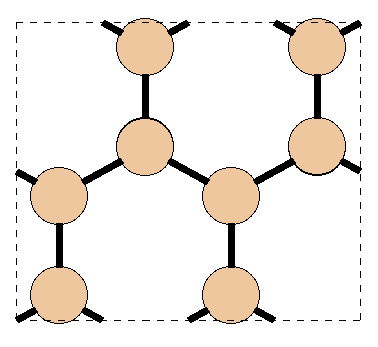

In [28]:
from IPython.display import Image
Image("tutorial_figures/atoms.png")

Now we create the noisy structure by adding noise to the positions and the cell:

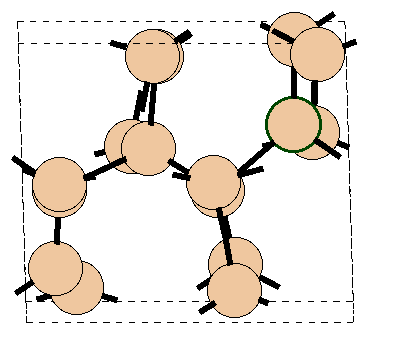

In [30]:
noise = .7
atms_noise = atoms.copy()
atms_noise.positions += (np.random.random(atms_noise.positions.shape)-0.5) * noise
atms_noise.cell += (np.random.random(atms_noise.cell.shape)-0.5) * noise
view(atms_noise)
Image("tutorial_figures/atoms_noise.png")

As we can see, the new structure is visibly deformed. With the use of a model trained on a Si16 dataset, the structure optimizer from `ase` and the `schnetpack.interfaces.ase_interface.SpkCalculator` we will now denoise our structure. Since we also added noise to the cell, we will wrap the `atoms` object in an `ExpCellFilter`. Now let`s run the optimization:

In [31]:
from schnetpack.transform import ASENeighborList
from schnetpack.interfaces.ase_interface import SpkCalculator
from ase.optimize.lbfgs import LBFGS
from ase.constraints import ExpCellFilter

atms_noise.calc = SpkCalculator(
    model_file="best_model",
    stress_key="stress",
    neighbor_list=ASENeighborList(cutoff=7.),
    energy_unit="eV",
)
optimizer = LBFGS(ExpCellFilter(atms_noise), force_consistent=False)
optimizer.run()

INFO:schnetpack.interfaces.ase_interface:Loading model from best_model
INFO:schnetpack.interfaces.ase_interface:Activating stress computation...


       Step     Time          Energy         fmax
LBFGS:    0 17:42:39   -10156.986328       16.3016
LBFGS:    1 17:42:41   -10153.250000       39.0364
LBFGS:    2 17:42:44   -10161.131836       14.5794
LBFGS:    3 17:42:46   -10162.789062       13.4939
LBFGS:    4 17:42:48   -10164.816406        4.4035
LBFGS:    5 17:42:50   -10165.672852       10.5363
LBFGS:    6 17:42:53   -10165.791016       25.7392
LBFGS:    7 17:42:56   -10166.937500        6.5541
LBFGS:    8 17:42:58   -10167.226562        9.7727
LBFGS:    9 17:43:01   -10167.777344        4.6592
LBFGS:   10 17:43:03   -10167.946289        9.8452
LBFGS:   11 17:43:06   -10168.323242        6.4965
LBFGS:   12 17:43:09   -10168.382812        5.1533
LBFGS:   13 17:43:11   -10168.646484        1.7557
LBFGS:   14 17:43:14   -10168.781250        1.4692
LBFGS:   15 17:43:16   -10168.887695        1.2823
LBFGS:   16 17:43:19   -10168.962891        0.6364
LBFGS:   17 17:43:22   -10169.011719        0.6363
LBFGS:   18 17:43:24   -10169.08

True

As we can see, the structure optimization has removed the noise, and we obtain our stable structure again:

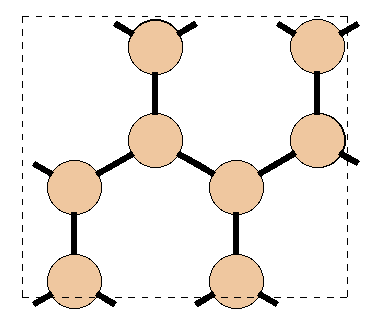

In [33]:
view(atms_noise)
Image("tutorial_figures/atoms_relaxed.png")